In [1]:
from __future__ import print_function, division, absolute_import
from six.moves import cPickle as pickle

In [2]:
import os, time

import numpy as np

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [114]:
from matplotlib import pyplot as plt
%matplotlib inline

### Loading data

In [3]:
image_size = 28
pixel_depth = 255
data_root = 'data'

In [64]:
pickle_file  = os.path.join(data_root, 'notMNIST.pickle')
keys = ["{0}_{1}".format(t,x) for t in ["train","test"] for x in "Xy"]+["labels_dict"]
with open(pickle_file, 'rb') as f:
    pi = pickle.load(f)
    for k in keys:
        globals()[k] = pi[k]
print(train_X.shape, test_X.shape)

(529114, 784) (18724, 784)


In [5]:
labels_dict

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9}

In [71]:
def to_onehot(labels, nclasses):
    onehot = np.zeros(shape=(len(labels), nclasses))
    for i, label in enumerate(labels):
        onehot[i, int(label)] = 1
    return onehot

test_y = to_onehot(test_y, nclasses)

In [72]:
def generate_batch(batch_size=10):
    global train_X, train_y, labels_dict
    i = 0
    while 1:
        if i+batch_size < len(train_X):
            raw_labels = train_y[i:i+batch_size]
            yield train_X[i:i+batch_size], to_onehot(raw_labels.flatten(), len(labels_dict))
        else:
            raw_labels = np.concatenate((train_y[i:], train_y[0:batch_size-(len(train_y)-i)]))
            yield np.concatenate((train_X[i:], train_X[0:batch_size-(len(train_X)-i)])),\
                    to_onehot(raw_labels.flatten(), len(labels_dict))

In [84]:
epochs = 100000
learning_rate = 1e-2
batch_size = 100
nclasses = len(labels_dict)

In [125]:
graph = tf.Graph()

with graph.as_default():
    with tf.name_scope("inputs"):
        train_inputs = tf.placeholder(tf.float32, shape=[batch_size, image_size*image_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, nclasses])

        W = tf.Variable(tf.random_normal(shape=[image_size*image_size, nclasses], stddev=0.1))
        b = tf.Variable(tf.zeros(shape=[nclasses]))

        logits = tf.add(tf.matmul(train_inputs, W), b, name="train_logits")

    with tf.name_scope("Loss"):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=train_labels))

    with tf.name_scope("Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
    with tf.name_scope("Predictions"):
        test_inputs = tf.placeholder(tf.float32, shape=[None, image_size*image_size])
        test_labels = tf.placeholder(tf.int32, shape=[None, nclasses])
        test_logits = tf.add(tf.matmul(test_inputs, W), b, name="test_logits")
        prediction_probs = tf.nn.softmax(test_logits)
        predictions = tf.argmax(prediction_probs, 1)
        
    with tf.name_scope("Accuracy"):
        target = tf.argmax(test_labels, 1)
        correct = tf.equal(predictions, target)
        accuracy = tf.reduce_mean(tf.cast(correct, "float"))
    init = tf.global_variables_initializer()

In [126]:
performance = dict()
accuracies = dict()
losses = dict()

batches = generate_batch(batch_size=batch_size)
with tf.Session(graph=graph) as sess:
    with tf.device("/gpu"):
        init.run()
        print("Variables initialized")
        average_loss = 0
        start = time.time()
        for e in range(1, epochs+1):
            batch_X, batch_y = batches.__next__()
            feed_dict = {train_inputs:batch_X, train_labels:batch_y}
            _, loss = sess.run([optimizer, cross_entropy], feed_dict=feed_dict)
            average_loss += np.mean(loss)
            
            if e%5000 == 0:
                print("Epoch {0}\nCross-entropy loss: {1}".format(e,average_loss/5000))
                
                performance[(e+1)*batch_size] = time.time()-start
                losses[(e+1)*batch_size] = average_loss
                average_loss = 0
                accuracy_ = sess.run([accuracy], feed_dict={test_inputs:test_X, test_labels:test_y})
                accuracy_ = np.mean(accuracy_)
                accuracies[(e+1)*batch_size] = accuracy_
                print("Accuracy:{0}".format(accuracy_))
                print("~"*30)

Variables initialized
Epoch 5000
Cross-entropy loss: 0.03620875772247091
Accuracy:0.711439847946167
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 10000
Cross-entropy loss: 0.002776519109494984
Accuracy:0.7164067625999451
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 15000
Cross-entropy loss: 0.0016331546500558034
Accuracy:0.7184362411499023
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 20000
Cross-entropy loss: 0.001163649382791482
Accuracy:0.7200384736061096
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 25000
Cross-entropy loss: 0.0009055497084977105
Accuracy:0.7213202118873596
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 30000
Cross-entropy loss: 0.0007418337108101695
Accuracy:0.7224951982498169
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 35000
Cross-entropy loss: 0.000628581315826159
Accuracy:0.7235633134841919
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 40000
Cross-entropy loss: 0.0005455136912642047
Accuracy:0.7242576479911804
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 45000
Cross-entropy loss: 0.00048194528466556223
Accuracy:0.724684894084930

In [141]:
training_sizes = [(i-100)/1e6 for i in sorted(performance.keys())]
training_sizes

[0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0]

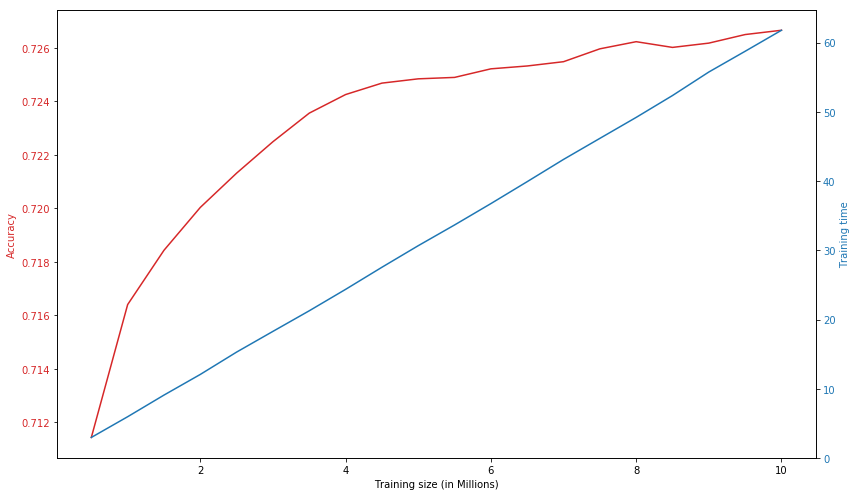

In [143]:
fig, ax1 = plt.subplots(figsize=(12,7))
plt.xticks = training_sizes
data1 = [performance[int(i*1e6+100)] for i in training_sizes]
data2 = [accuracies[int(i*1e6+100)] for i in training_sizes]

color = 'tab:red'
ax1.set_xlabel('Training size (in Millions)')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(training_sizes, data2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Training time', color=color)
ax2.plot(training_sizes, data1, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

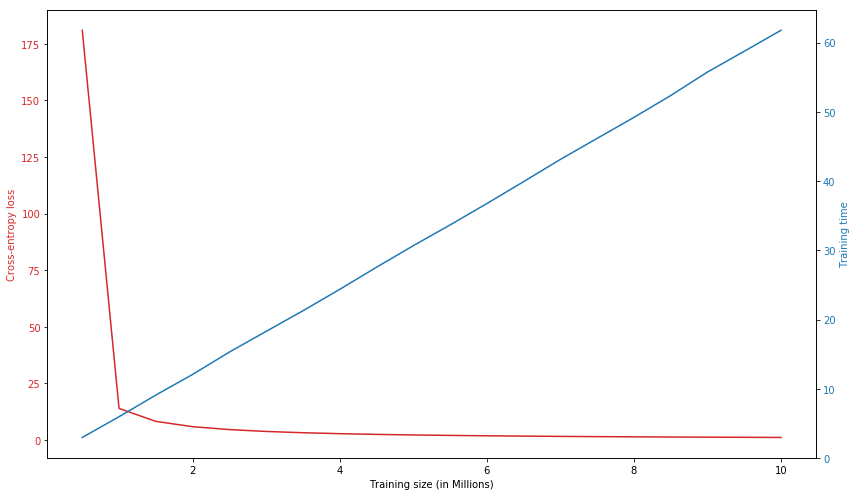

In [145]:
fig, ax1 = plt.subplots(figsize=(12,7))
data1 = [performance[int(i*1e6+100)] for i in training_sizes]
data2 = [losses[int(i*1e6+100)] for i in training_sizes]

color = 'tab:red'
ax1.set_xlabel('Training size (in Millions)')
ax1.set_ylabel('Cross-entropy loss', color=color)
ax1.plot(training_sizes, data2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Training time', color=color)
ax2.plot(training_sizes, data1, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped